# **<center> Geography in Language Models </center>**

## Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from tqdm import tqdm

In [2]:
import warnings

In [3]:
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config Completer.use_jedi = False

In [4]:
from scipy import stats
from scipy.stats import pearsonr
from scipy.spatial import distance

In [5]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier,MLPRegressor

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score

In [7]:
from sklearn.metrics import r2_score as r2, explained_variance_score as evs, mean_squared_error as mse, make_scorer

## Data Loading

In [8]:
models = ['bert','bertLarge','gpt2','roberta','robertaLarge']
contexts = ['I come from', 'He lives in', 'She moved to']
short_ctxts = ['come','lives','moved']

In [9]:
cities = pd.read_csv('./csv/worldcitiespop.csv',header=0,dtype={'AccentCity':'str','Region':'object'}).dropna().drop('Region',axis=1)
cities = cities[cities.Population>100000].reset_index(drop=True)
cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
3,af,baglan,Baglan,108481.0,36.130684,68.708286
4,af,gardez,Gardez,103732.0,33.597439,69.225922
...,...,...,...,...,...,...
3522,zw,gweru,Gweru,201879.0,-19.450000,29.816667
3523,zw,harare,Harare,2213701.0,-17.817778,31.044722
3524,zw,kadoma,Kadoma,100276.0,-18.350000,29.916667
3525,zw,kwekwe,Kwekwe,116332.0,-18.916667,29.816667


In [10]:
cities500k = cities[cities.Population > 5e5]
cities1M = cities[cities.Population > 1e6]

In [11]:
countries = pd.read_csv('./csv/countries_extended.csv',keep_default_na=False,na_values=['','..']).drop('Unnamed: 0',axis=1).sort_values('Code',ignore_index=True)
countries

,Name,Code,Latitude,Longitude,HDI,Population,GDP,GPD per cap.,GNI per cap.
0,Andorra,AD,42.5000,1.5000,0.868,0.1,NaN,NaN,56000.0
1,United Arab Emirates,AE,24.0000,54.0000,0.890,9.8,655.8,67119.0,67462.0
2,Afghanistan,AF,33.0000,65.0000,0.511,38.0,83.8,2202.0,2229.0
3,Antigua and Barbuda,AG,17.0500,-61.8000,0.778,0.1,2.1,21908.0,20895.0
4,Anguilla,AI,18.2500,-63.1667,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
244,Yemen,YE,15.0000,48.0000,0.470,29.2,NaN,NaN,1594.0
245,Mayotte,YT,-12.8333,45.1667,NaN,NaN,NaN,NaN,NaN
246,South Africa,ZA,-29.0000,24.0000,0.709,58.6,730.9,12482.0,12129.0
247,Zambia,ZM,-15.0000,30.0000,0.584,17.9,62.1,3479.0,3326.0


In [12]:
datasets = {model_name : {ctx : pd.DataFrame(np.load('embd_files/4layers_'+model_name+'_'+ctx+'_cities.npy')) for ctx in short_ctxts} for model_name in models}
datasets_countries = {model_name : {ctx : pd.DataFrame(np.load('embd_files/4layers_'+model_name+'_'+ctx+'_countries.npy')) for ctx in short_ctxts} for model_name in models}
contexts.append('average of 3')
short_ctxts.append('avg')
for model_name in models :
    concat = pd.concat( (datasets[model_name]['come'],datasets[model_name]['lives'],datasets[model_name]['moved']) )
    datasets[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_countries[model_name]['come'],datasets_countries[model_name]['lives'],datasets_countries[model_name]['moved']) )
    datasets_countries[model_name]['avg'] = concat.groupby(concat.index).mean()


In [13]:
w2v_datasets = {'cities' : pd.DataFrame(np.load('embd_files/w2v_cities.npy')), 'countries' : pd.DataFrame(np.load('embd_files/w2v_countries.npy'))}

w2v_banned_cities = np.argwhere(w2v_datasets['cities'].isna()[0].to_numpy() ).flatten()
w2v_banned_countries = np.sort(countries.Code)[np.argwhere(w2v_datasets['countries'].isna()[0].to_numpy() ).flatten()]

In [14]:
borders = dict()
DF_borders = pd.read_csv('./csv/geodatasource_country_borders.csv',keep_default_na=False)
for row in DF_borders.iterrows():
    relation = row[1]
    if relation.country_code in borders:
        borders[relation.country_code].append(relation.country_border_code)
    else:
        if relation.country_border_code :    
            borders[relation.country_code] = [relation.country_border_code]
        else:
            borders[relation.country_code] = []

## Tools and functions

In [15]:
def dist_from_gps(l1,L1,l2,L2):
    '''
    Compute distances in km between two points from their GPS coordinates
    ------------
    inputs :
    * l1 : latitude of the first point
    * L1 : longitude of the first point
    * l2 : latitude of the second point
    * L2 : longitude of the second point
    ------------
    output : distance in km
    '''
    a = np.sin( (l1-l2)*np.pi/360 )**2 + np.cos((l1)*np.pi/180) * np.cos((l2)*np.pi/180) * np.sin( (L1-L2)*np.pi/360 )**2
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = 6371*c
    return(np.round(d,2))

In [16]:
def gps_metrics(y1,y2):
    pairsGPS = np.concatenate( (y1,y2), axis=1).T
    dists = dist_from_gps(pairsGPS[0],pairsGPS[1],pairsGPS[2],pairsGPS[3])
    return dists.mean().round(1)

In [17]:
def get_country_index(country):
    return countries[countries.Code == country].index[0]

In [18]:
def get_embdgs(country1,country2,embeddings):
    i1 = get_country_index(country1)
    i2 = get_country_index(country2)
    return (embeddings.loc[i1],embeddings.loc[i2])

In [19]:
def find_non_borders(n,rng=np.random.default_rng(seed=0),banned_countries=[]):
    countries_list = countries.Code.unique()
    pairs_list = []
    while len(pairs_list)<n:
        c1,c2 = rng.choice(countries_list,2)
        if c1 in banned_countries or c2 in banned_countries:
            pass
        else:
            if c2 in borders[c1]:
                pass
            else:
                pairs_list.append((c1,c2))
    return pairs_list

In [20]:
def create_border_dataset(embdgs,non_border_size=500,out_pairs=False,seed=0,banned_countries=[]):
    rng = np.random.default_rng(seed=seed)
    non_borders_pairs = find_non_borders(non_border_size,rng,banned_countries)
    nb_embdgs = np.empty( (non_border_size,2,embdgs.shape[1]), dtype='float64' )
    for i,pair in tqdm(enumerate(non_borders_pairs),total=len(non_borders_pairs),desc='non border pairs',file=sys.stdout):
        c1,c2 = pair
        nb_embdgs[i] = get_embdgs(c1,c2,embdgs)
    nb_y = np.zeros(non_border_size,dtype='int32')
    borders_pairs = [ (c1,c2) for c1 in borders.keys() for c2 in borders[c1]]
    current_idx = 0
    while current_idx<len(borders_pairs):
        c1,c2 = borders_pairs[current_idx]
        if c1 in banned_countries or c2 in banned_countries:
            borders_pairs.pop(current_idx)
        else:
            current_idx+=1
    b_embdgs = np.empty( (len(borders_pairs),2,embdgs.shape[1]), dtype='float64' )
    for i,pair in tqdm(enumerate(borders_pairs),total=len(borders_pairs),desc='border pairs',file=sys.stdout):
        c1,c2 = pair
        b_embdgs[i] = get_embdgs(c1,c2,embdgs)
    b_y = np.ones(len(borders_pairs),dtype='int32')
    X = np.concatenate((nb_embdgs,b_embdgs))
    y = np.concatenate((nb_y,b_y))
    pairs = np.array(non_borders_pairs+borders_pairs)
    shuffle_order = rng.permutation(len(y))
    pairs = pairs[shuffle_order]
    X = X[shuffle_order]
    y = y[shuffle_order]
    if out_pairs:
        return (X,y,pairs)
    else:
        return (X,y)

In [21]:
def create_gps_dataset(embeddings,for_countries=False):
    X = embeddings
    if for_countries:
        y = countries[['Latitude','Longitude']]
    else:
        y = cities[['Latitude','Longitude']]
    X = X[~y.isna().T.any()]
    y = y[~y.isna().T.any()][~X.isna().T.any()]
    X = X[~X.isna().T.any()]
    return (X,y)

In [22]:
def create_population_dataset(embeddings):
    X = embeddings
    y = cities.Population
    X = X[~y.isna()]
    y = y[~y.isna()][~X.isna().T.any()]
    X = X[~X.isna().T.any()]
    return (X,y)

In [23]:
def create_CountryProps_dataset(embeddings,attribute='Population'):
    X = embeddings
    y = countries[attribute]
    X = X[~y.isna()]
    y = y[~y.isna()][~X.isna().T.any()]
    X = X[~X.isna().T.any()]
    return (X,y)

In [24]:
def cosine_sim(x,y):
    return 1-distance.cosine(x,y)

def createRSM(datasets,model_name,ctx='avg',source='cities',is_static=False):
    if is_static :
        X = datasets[source]
    else:
        X = datasets[model_name][ctx]
    dists = distance.pdist(X, metric=cosine_sim)
    rsm_arr = distance.squareform(dists)+np.diag(np.ones(len(X)))
    np.save(file='./rsm/4layers_'+model_name+'_'+source+'_RSM',arr=rsm_arr)

In [25]:
def flatten_triangle(arr):
    '''
    Return the flattened lower triangle of a symetric matrix
    '''
    return np.tril(arr).flatten()[(np.tril(arr,k=-1).flatten()>0 )]

In [26]:
def get_patch(rsm_arr,country1,country2,out_lev=False,prefilter=None):
    if prefilter is None:
        c1_filter = cities.Country==country1
        c2_filter = cities.Country==country2
    else:
        c1_filter = cities.loc[prefilter].Country==country1
        c2_filter = cities.loc[prefilter].Country==country2
        
    if out_lev:
        names1 = cities.AccentCity[c1_filter]
        names2 = cities.AccentCity[c2_filter]
        lev_dists = [ [LevDist(n1,n2) for n2 in names2] for n1 in names1]
        return (rsm_arr[c1_filter,:][:,c2_filter],np.array(lev_dists))
    else:
        return rsm_arr[c1_filter,:][:,c2_filter]

In [27]:
def compare_models(datasets_dict,model,f_dataset,model_kwargs=dict(),f_dataset_kwargs=dict(),ctx='avg',LMs=['bert','bertLarge'],
                   n_test=10,seed=0,return_scores=False,plot_scores=True,fig_name='',fig_title='',
                   y_label='',ylims=None,metrics=None,crossvalid=False):
    if not(return_scores or plot_scores):
        raise ValueError('Please make a useful call of this function and either return scores, plot them or both.')
    scores = np.empty((2,len(LMs)))
    baseline = np.empty((2,1))
    
    for i,lm in enumerate(LMs):
        rng = np.random.default_rng(seed=seed)
        print(lm+' -----------------------')
        #get datasets
        embeddings = datasets_dict[lm][ctx]
        X,y = f_dataset(embeddings,**f_dataset_kwargs)
        if len(X.shape)!=2:
            X = X.reshape(X.shape[0],np.prod(X.shape[1:]))
        #normal task
        r_state = rng.integers(1000)
        if not crossvalid:
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=r_state)
            task_model = model(**model_kwargs)
            task_model.fit(X_train,y_train)
            if metrics is None :
                scores[0][i] = task_model.score(X_test,y_test).round(4)
            else:
                y_preds = task_model.predict(X_test)
                scores[0][i] = metrics(y_test,y_preds).round(4)
        else:
            scores[0][i] = cross_val_score(model(**model_kwargs), X, y, cv=5,scoring=make_scorer(metrics),n_jobs=-1).mean().round(4)
        
                                
        #control task
        random_scores = np.empty(n_test)
        for j in tqdm(range(n_test),desc='random control',total=n_test,file=sys.stdout):
            y_rand = rng.permutation(y)
            r_state = rng.integers(1000)
            X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X,y_rand,test_size=0.2,random_state=r_state)
            task_model = model(**model_kwargs)
            task_model.fit(X_rand_train,y_rand_train)
            if metrics is None:
                random_scores[j]= task_model.score(X_rand_test,y_rand_test)
            else:
                y_rand_preds = task_model.predict(X_rand_test)
                random_scores[j]= metrics(y_rand_test,y_rand_preds)
        scores[1][i] = random_scores.mean().round(4)
        
    
    if plot_scores:

        locs = np.arange(len(LMs))  # label locations
        width = 0.35  # the width of the bars


        fig, ax = plt.subplots(figsize=(15,10))
        fig.set_facecolor('white')
        rect1 = ax.bar(locs -0.5*width, scores[0], width, label='Task score')
        rect2 = ax.bar(locs +0.5*width, scores[1], width, label='Random control task score')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        if y_label:
            ax.set_ylabel(y_label, fontdict = {'fontsize' : 20})
        if ylims is not None:
            plt.ylim(ylims)
        if fig_title:
            ax.set_title(fig_title, fontdict = {'fontsize' : 20})
        
        
        ax.set_xticks(locs)
        ax.set_xticklabels(LMs, fontdict = {'fontsize' : 20})
        ax.bar_label(rect1, padding=3, fontsize=20)
        ax.bar_label(rect2, padding=3, fontsize=20)

        ax.legend(fontsize=20)

        fig.tight_layout()
        
        if fig_name:
            plt.savefig('img/'+fig_name,dpi=200, facecolor=fig.get_facecolor())
        plt.show()
    if return_scores:
        return scores

In [28]:
def compare_models_wBaseline(datasets_dict,model,f_dataset,baseline_embeddings,model_kwargs=dict(),f_dataset_kwargs=dict(),f_dataset_baseline_kwargs=dict(),ctx='avg',LMs=['bert','bertLarge'],
                   n_test=10,seed=0,return_scores=False,plot_scores=True,fig_name='',fig_title='',
                   y_label='',ylims=None,metrics=None,crossvalid=False):
    if not(return_scores or plot_scores):
        raise ValueError('Please make a useful call of this function and either return scores, plot them or both.')
    scores = np.empty((2,len(LMs)))
    baseline = np.empty((2,1))
    
    for i,lm in enumerate(LMs):
        rng = np.random.default_rng(seed=seed)
        print(lm+' -----------------------')
        #get datasets
        embeddings = datasets_dict[lm][ctx]
        X,y = f_dataset(embeddings,**f_dataset_kwargs)
        if len(X.shape)!=2:
            X = X.reshape(X.shape[0],np.prod(X.shape[1:]))
        #normal task
        r_state = rng.integers(1000)
        if not crossvalid:
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=r_state)
            task_model = model(**model_kwargs)
            task_model.fit(X_train,y_train)
            if metrics is None :
                scores[0][i] = task_model.score(X_test,y_test).round(4)
            else:
                y_preds = task_model.predict(X_test)
                scores[0][i] = metrics(y_test,y_preds).round(4)
        else:
            scores[0][i] = cross_val_score(model(**model_kwargs), X, y, cv=5,scoring=make_scorer(metrics),n_jobs=-1).mean().round(4)
        
                                
        #control task
        random_scores = np.empty(n_test)
        for j in tqdm(range(n_test),desc='random control',total=n_test,file=sys.stdout):
            y_rand = rng.permutation(y)
            r_state = rng.integers(1000)
            X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X,y_rand,test_size=0.2,random_state=r_state)
            task_model = model(**model_kwargs)
            task_model.fit(X_rand_train,y_rand_train)
            if metrics is None:
                random_scores[j]= task_model.score(X_rand_test,y_rand_test)
            else:
                y_rand_preds = task_model.predict(X_rand_test)
                random_scores[j]= metrics(y_rand_test,y_rand_preds)
        scores[1][i] = random_scores.mean().round(4)
        
    print('baseline -----------------------')
    #get datasets
    X,y = f_dataset(baseline_embeddings,**f_dataset_baseline_kwargs)
    if len(X.shape)!=2:
        X = X.reshape(X.shape[0],np.prod(X.shape[1:]))
    #normal task - baseline
    r_state = rng.integers(1000)
    if not crossvalid:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=r_state)
        task_model = model(**model_kwargs)
        task_model.fit(X_train,y_train)
        if metrics is None :
            baseline[0] = task_model.score(X_test,y_test).round(4)
        else:
            y_preds = task_model.predict(X_test)
            baseline[0] = metrics(y_test,y_preds).round(4)
    else:
        baseline[0] = cross_val_score(model(**model_kwargs), X, y, cv=5,scoring=make_scorer(metrics),n_jobs=-1).mean().round(4)

    #control task - baseline
    random_scores = np.empty(n_test)
    for j in tqdm(range(n_test),desc='random control',total=n_test,file=sys.stdout):
        y_rand = rng.permutation(y)
        r_state = rng.integers(1000)
        X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X,y_rand,test_size=0.2,random_state=r_state)
        task_model = model(**model_kwargs)
        task_model.fit(X_rand_train,y_rand_train)
        if metrics is None:
            random_scores[j]= task_model.score(X_rand_test,y_rand_test)
        else:
            y_rand_preds = task_model.predict(X_rand_test)
            random_scores[j]= metrics(y_rand_test,y_rand_preds)
    baseline[1] = random_scores.mean().round(4)
    scores = np.hstack((baseline,scores))

    if plot_scores:

        locs = np.arange(len(LMs)+1)  # label locations
        width = 0.35  # the width of the bars


        fig, ax = plt.subplots(figsize=(15,10))
        fig.set_facecolor('white')
        rect1 = ax.bar(locs -0.5*width, scores[0], width, label='Task score')
        rect2 = ax.bar(locs +0.5*width, scores[1], width, label='Random control task score')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        if y_label:
            ax.set_ylabel(y_label, fontdict = {'fontsize' : 20})
        if ylims is not None:
            plt.ylim(ylims)
        if fig_title:
            ax.set_title(fig_title, fontdict = {'fontsize' : 20})
        
        
        ax.set_xticks(locs)
        ax.set_xticklabels(['baseline']+LMs, fontdict = {'fontsize' : 20})
        ax.bar_label(rect1, padding=3, fontsize=20)
        ax.bar_label(rect2, padding=3, fontsize=20)

        ax.legend(fontsize=20)

        fig.tight_layout()
        
        if fig_name:
            plt.savefig('img/'+fig_name,dpi=200, facecolor=fig.get_facecolor())
        plt.show()
    if return_scores:
        return scores

## Predicting country borders from embedding

In [134]:
X,y, pairs = create_border_dataset(w2v_datasets['countries'],non_border_size=500,out_pairs=True,banned_countries=w2v_banned_countries)

border pairs: 100%|██████████| 622/622 [00:00<00:00, 800.49it/s]


In [135]:
X_flat = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
X_train, X_test, y_train, y_test = train_test_split(X_flat,y,test_size=0.2)

In [136]:
mlp = MLPClassifier(max_iter=500,random_state=0)
mlp.fit(X_train,y_train)
mlp.score(X_test,y_test)

0.84

In [137]:
svm = SVC(kernel='rbf',max_iter=10000)
svm.fit(X_train,y_train)
svm.score(X_test,y_test)

0.7688888888888888

In [138]:
#Control task

n_test = 10
random_scores = np.empty(n_test)
rng = np.random.default_rng(seed=0)
for i in tqdm(range(n_test),desc='Random control',total=n_test,file=sys.stdout):
    y_rand = rng.permutation(y)
    X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X_flat,y_rand,test_size=0.2)
    clf_r = MLPClassifier(max_iter=500)
    clf_r.fit(X_rand_train,y_rand_train)
    rand_preds = clf_r.predict(X_rand_test)
    random_scores[i]=sum(rand_preds==y_rand_test)/len(rand_preds)
print('random control score : '+str(random_scores.mean().round(4)*100))

Random control: 100%|██████████| 10/10 [00:57<00:00,  5.75s/it]
random control score : 50.8


bert -----------------------
random control: 100%|███████████████████████████| 10/10 [01:32<00:00,  9.21s/it]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [01:24<00:00,  8.42s/it]
gpt2 -----------------------
random control: 100%|███████████████████████████| 10/10 [01:59<00:00, 11.96s/it]
roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [01:54<00:00, 11.43s/it]
robertaLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [02:35<00:00, 15.58s/it]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [01:00<00:00,  6.03s/it]


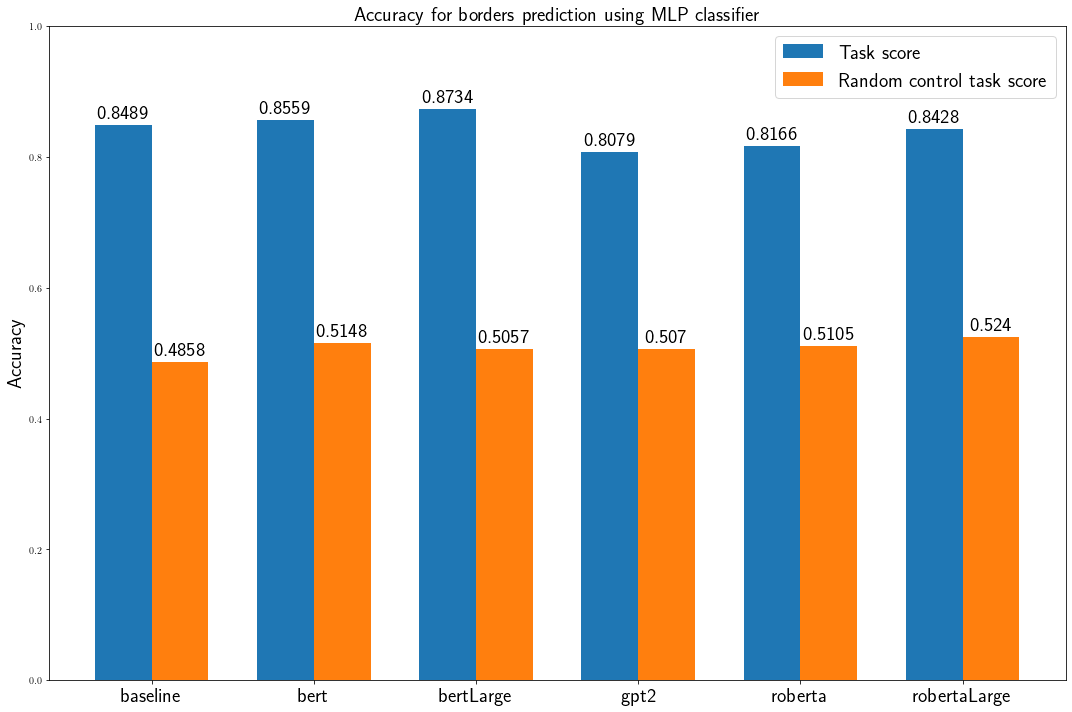

In [31]:
border_scores = compare_models_wBaseline(model=MLPClassifier,model_kwargs={'max_iter':1000,'solver':'adam','random_state':0},
               datasets_dict=datasets_countries, baseline_embeddings = w2v_datasets['countries'],
               f_dataset=create_border_dataset,f_dataset_kwargs={'non_border_size':500},
               LMs=models,ylims=(0,1),y_label='Accuracy',
               f_dataset_baseline_kwargs={'non_border_size':500,'banned_countries':w2v_banned_countries},
               fig_title='Accuracy for borders prediction using MLP classifier',
              fig_name='final_borders_mlp.png',return_scores=True)

## Predicting Country attributes

bert -----------------------
random control: 100%|█████████████████████████████| 2/2 [00:07<00:00,  3.84s/it]
bertLarge -----------------------
random control: 100%|█████████████████████████████| 2/2 [00:07<00:00,  3.75s/it]
gpt2 -----------------------
random control: 100%|█████████████████████████████| 2/2 [00:19<00:00,  9.53s/it]
roberta -----------------------
random control: 100%|█████████████████████████████| 2/2 [00:12<00:00,  6.15s/it]
robertaLarge -----------------------
random control: 100%|█████████████████████████████| 2/2 [00:16<00:00,  8.25s/it]
baseline -----------------------
random control: 100%|█████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


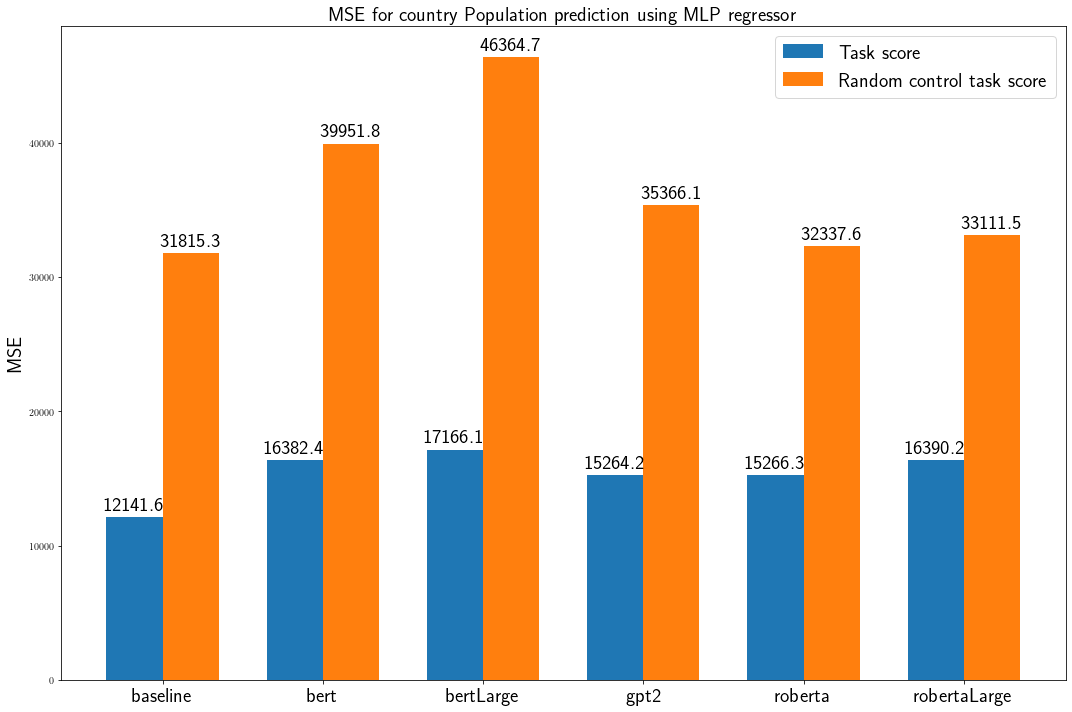

In [64]:
attr = 'Population'

population_scores = compare_models_wBaseline(model=MLPRegressor,model_kwargs={'max_iter':2000,'random_state':0,'solver':'lbfgs'},
               datasets_dict=datasets_countries, baseline_embeddings = w2v_datasets['countries'],
               f_dataset=create_CountryProps_dataset,f_dataset_kwargs={'attribute':attr},
               LMs=models,y_label='MSE',
               f_dataset_baseline_kwargs={'attribute':attr},
               fig_title='MSE for country '+attr+' prediction using MLP regressor',
               fig_name = 'final_'+attr.lower()+'_countries_mlp_mse.png',n_test=2,seed=0,return_scores=True,metrics=mse,crossvalid=True)

bert -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 23.98it/s]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 24.72it/s]
gpt2 -----------------------
random control:  20%|█████▌                      | 2/10 [00:00<00:01,  7.07it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 620.9734319526397, tolerance: 395.24338189743594
  positive)


random control:  30%|████████▍                   | 3/10 [00:00<00:00,  7.05it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1069.2092782322725, tolerance: 408.19024735897443
  positive)


random control:  60%|████████████████▊           | 6/10 [00:00<00:00,  7.52it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.4580524470075, tolerance: 408.47007674358974
  positive)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10166.16148363307, tolerance: 407.2611198974359
  positive)


random control:  80%|██████████████████████▍     | 8/10 [00:01<00:00,  7.23it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1739.5705402237581, tolerance: 410.1732911474359
  positive)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7028.998208162455, tolerance: 410.2615315576924
  positive)


random control: 100%|███████████████████████████| 10/10 [00:01<00:00,  7.03it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1804.9058530519687, tolerance: 409.1143766858976
  positive)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6849.913394394476, tolerance: 408.56481135897445
  positive)



roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 40.19it/s]
robertaLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 27.18it/s]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 90.16it/s]


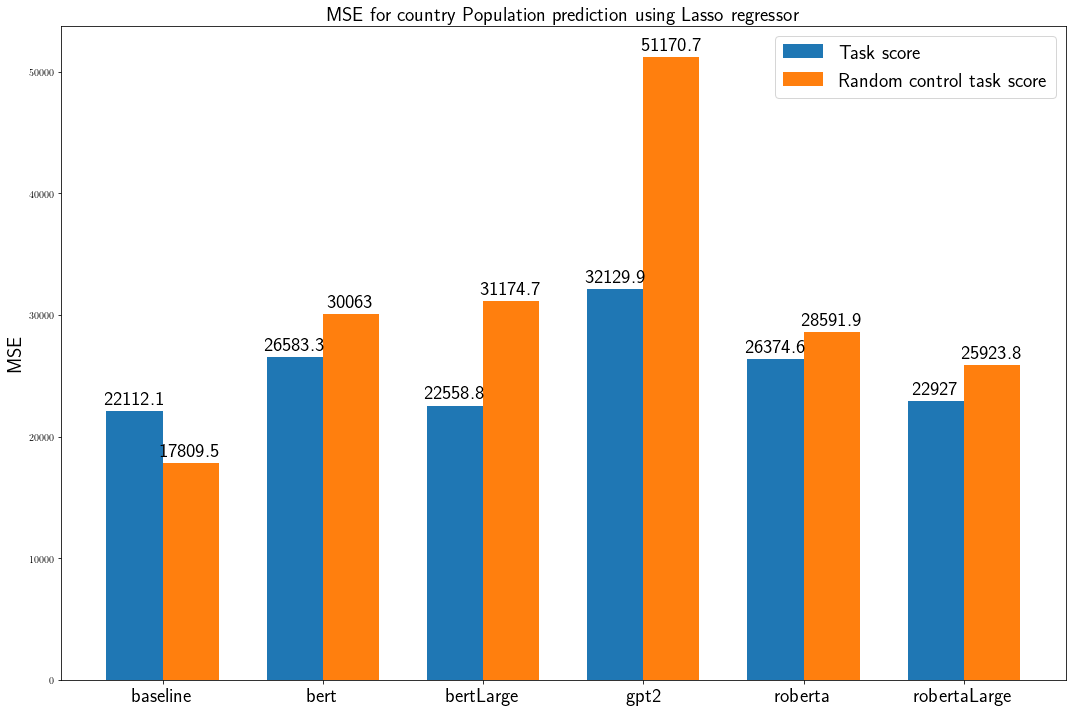

In [65]:
attr = 'Population'

population_scores = compare_models_wBaseline(model=linear_model.Lasso,model_kwargs={'max_iter':2000,'random_state':0},
               datasets_dict=datasets_countries, baseline_embeddings = w2v_datasets['countries'],
               f_dataset=create_CountryProps_dataset,f_dataset_kwargs={'attribute':attr},
               LMs=models,y_label='MSE',
               f_dataset_baseline_kwargs={'attribute':attr},
               fig_title='MSE for country '+attr+' prediction using Lasso regressor',
               fig_name = 'final_'+attr.lower()+'_countries_lasso_mse.png',n_test=10,seed=0,return_scores=True,metrics=mse,crossvalid=True)

warnings.filterwarnings("default")

## Predicting cities' population

bert -----------------------
random control: 100%|███████████████████████████| 10/10 [00:44<00:00,  4.44s/it]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:59<00:00,  5.93s/it]
gpt2 -----------------------
random control: 100%|███████████████████████████| 10/10 [00:43<00:00,  4.36s/it]
roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [00:45<00:00,  4.59s/it]
robertaLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:58<00:00,  5.83s/it]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


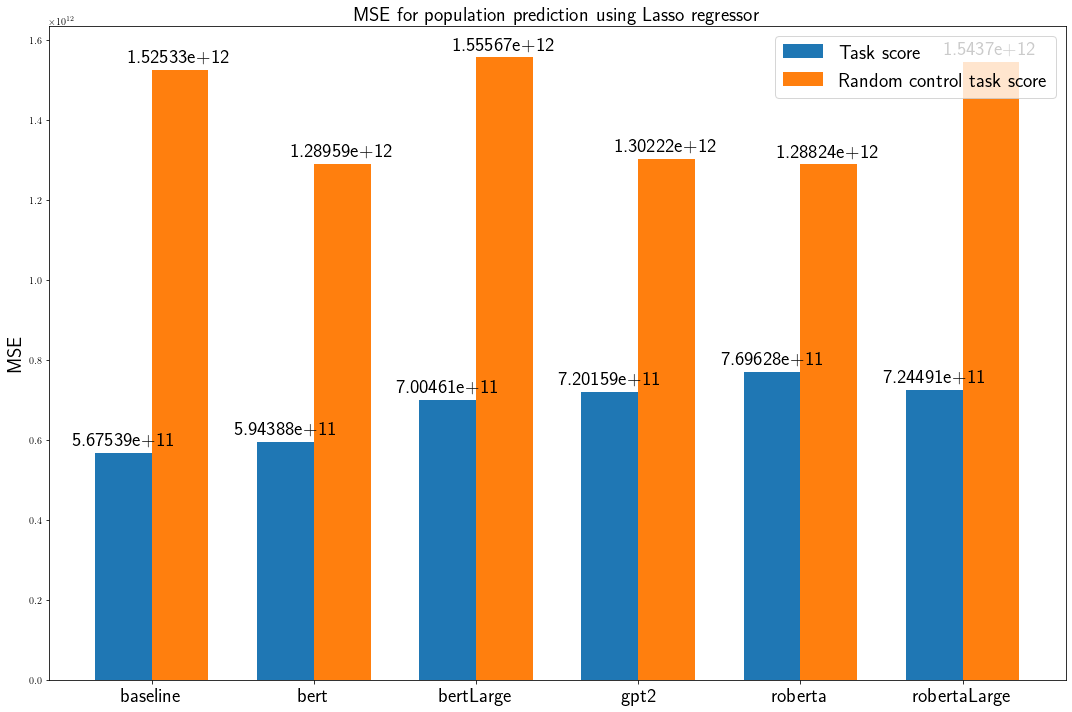

In [67]:
warnings.filterwarnings("ignore")
compare_models_wBaseline(model=linear_model.Lasso,model_kwargs={'max_iter':2000,'random_state':0},
               datasets_dict=datasets,
               f_dataset=create_population_dataset,f_dataset_kwargs={},
               f_dataset_baseline_kwargs={}, baseline_embeddings=w2v_datasets['cities'],
               LMs=models,y_label='MSE',
               fig_title='MSE for population prediction using Lasso regressor',
              fig_name='final_population_cities_lasso_mse.png',n_test=10,metrics=mse)
warnings.filterwarnings("default")

bert -----------------------
random control: 100%|██████████████████████████| 10/10 [21:11<00:00, 127.15s/it]
bertLarge -----------------------
random control: 100%|██████████████████████████| 10/10 [28:17<00:00, 169.76s/it]
gpt2 -----------------------
random control: 100%|██████████████████████████| 10/10 [20:56<00:00, 125.62s/it]
roberta -----------------------
random control: 100%|██████████████████████████| 10/10 [21:18<00:00, 127.85s/it]
robertaLarge -----------------------
random control: 100%|██████████████████████████| 10/10 [29:28<00:00, 176.87s/it]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [07:13<00:00, 43.37s/it]


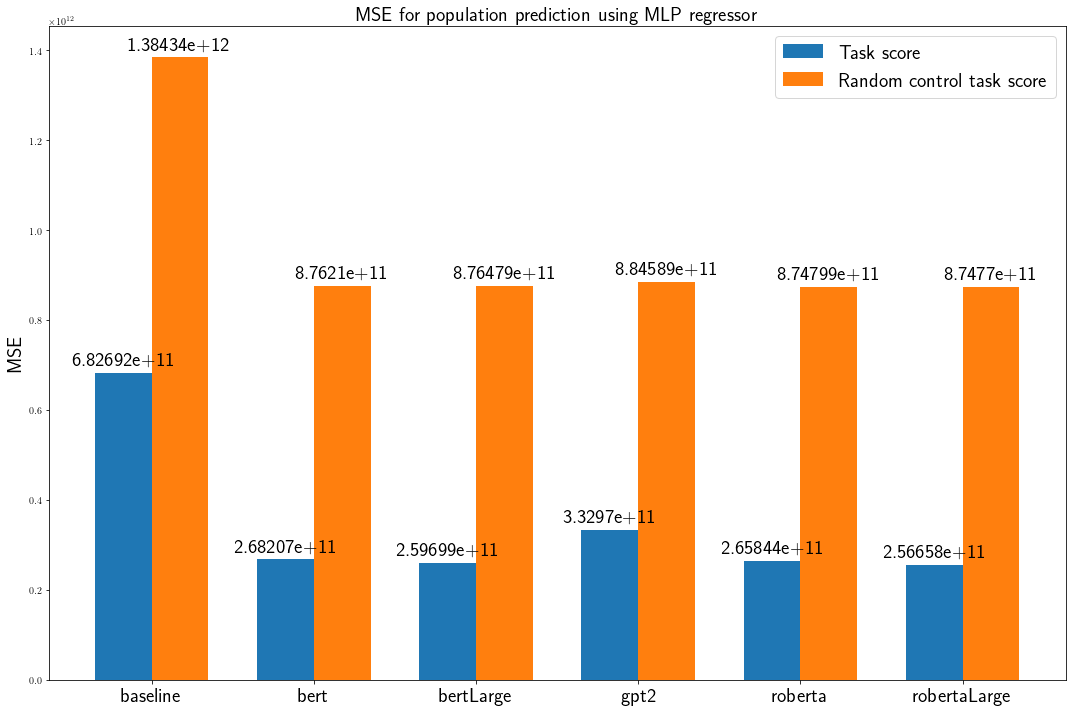

In [68]:
warnings.filterwarnings("ignore")
compare_models_wBaseline(model=MLPRegressor,model_kwargs={'max_iter':2000,'random_state':0},
               datasets_dict=datasets,
               f_dataset=create_population_dataset,f_dataset_kwargs={},
               f_dataset_baseline_kwargs={}, baseline_embeddings=w2v_datasets['cities'],
               LMs=models,y_label='MSE',
               fig_title='MSE for population prediction using MLP regressor',
              fig_name='final_population_cities_mlp_mse.png',n_test=10,metrics=mse)
warnings.filterwarnings("default")

## Predicting GPS coordinates

bert -----------------------
random control: 100%|███████████████████████████| 10/10 [00:01<00:00,  7.54it/s]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:01<00:00,  8.79it/s]
gpt2 -----------------------
random control: 100%|███████████████████████████| 10/10 [00:22<00:00,  2.25s/it]
roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 13.19it/s]
robertaLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:01<00:00,  9.91it/s]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 37.98it/s]


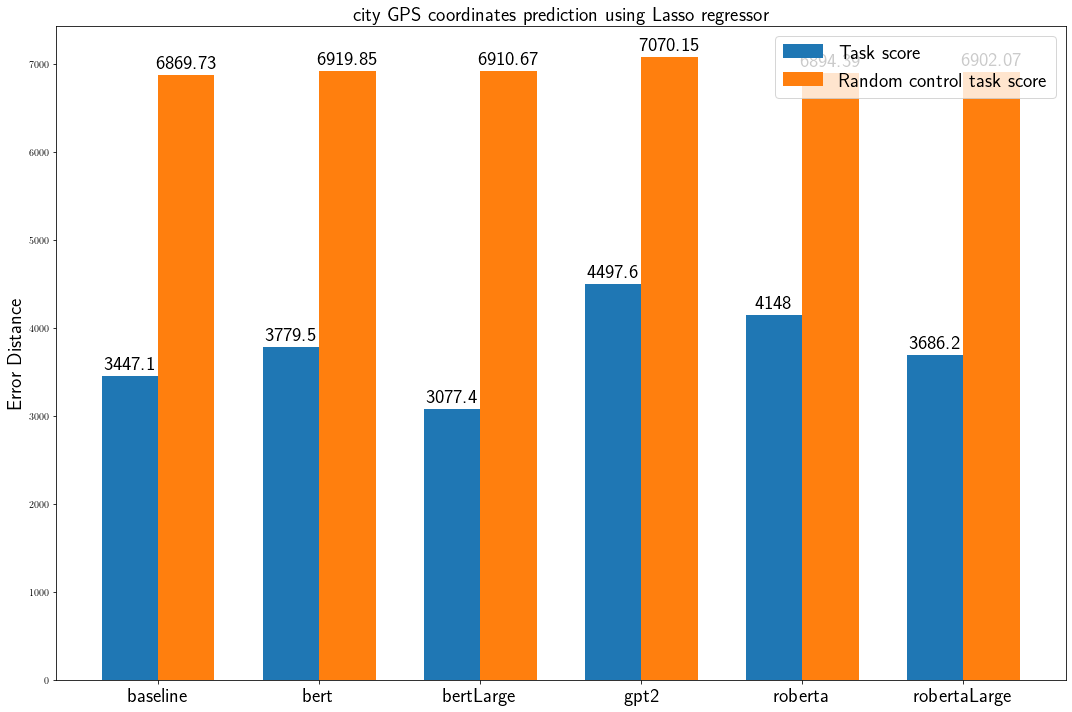

In [85]:
#warnings.filterwarnings("ignore")
coords_cities_scores_lasso = compare_models_wBaseline(model=linear_model.Lasso,model_kwargs={'max_iter':2000,'random_state':0,'alpha':0.5},
               datasets_dict=datasets, baseline_embeddings = w2v_datasets['cities'],
               f_dataset=create_gps_dataset,f_dataset_kwargs={},
               LMs=models,y_label='Error Distance',
               f_dataset_baseline_kwargs={},
               fig_title='city GPS coordinates prediction using Lasso regressor',
              fig_name='final_cities_gps_lasso.png',n_test=10,metrics=gps_metrics,seed=0,return_scores=True)

warnings.filterwarnings("default")

bert -----------------------
random control: 100%|███████████████████████████| 10/10 [00:01<00:00,  9.56it/s]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 15.19it/s]
gpt2 -----------------------
random control:  10%|██▊                         | 1/10 [00:00<00:03,  2.45it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.76030132109736, tolerance: 109.14206483027179
  positive)


random control:  20%|█████▌                      | 2/10 [00:00<00:03,  2.05it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2807.87302975031, tolerance: 106.15679659828744
  positive)


random control:  30%|████████▍                   | 3/10 [00:01<00:03,  2.03it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408.477892530751, tolerance: 115.20422204275947
  positive)


random control:  40%|███████████▏                | 4/10 [00:01<00:02,  2.00it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380.7352268939103, tolerance: 102.30616288072343
  positive)


random control:  60%|████████████████▊           | 6/10 [00:02<00:01,  2.14it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1218.2895623001168, tolerance: 110.57347064343351
  positive)


random control:  80%|██████████████████████▍     | 8/10 [00:03<00:00,  2.18it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.0459585985373, tolerance: 108.73618554597064
  positive)


random control:  90%|█████████████████████████▏  | 9/10 [00:04<00:00,  2.24it/s]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251.6661178894828, tolerance: 106.90728514395067
  positive)


random control: 100%|███████████████████████████| 10/10 [00:04<00:00,  2.18it/s]
roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 21.88it/s]
robertaLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 13.44it/s]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [00:00<00:00, 53.95it/s]


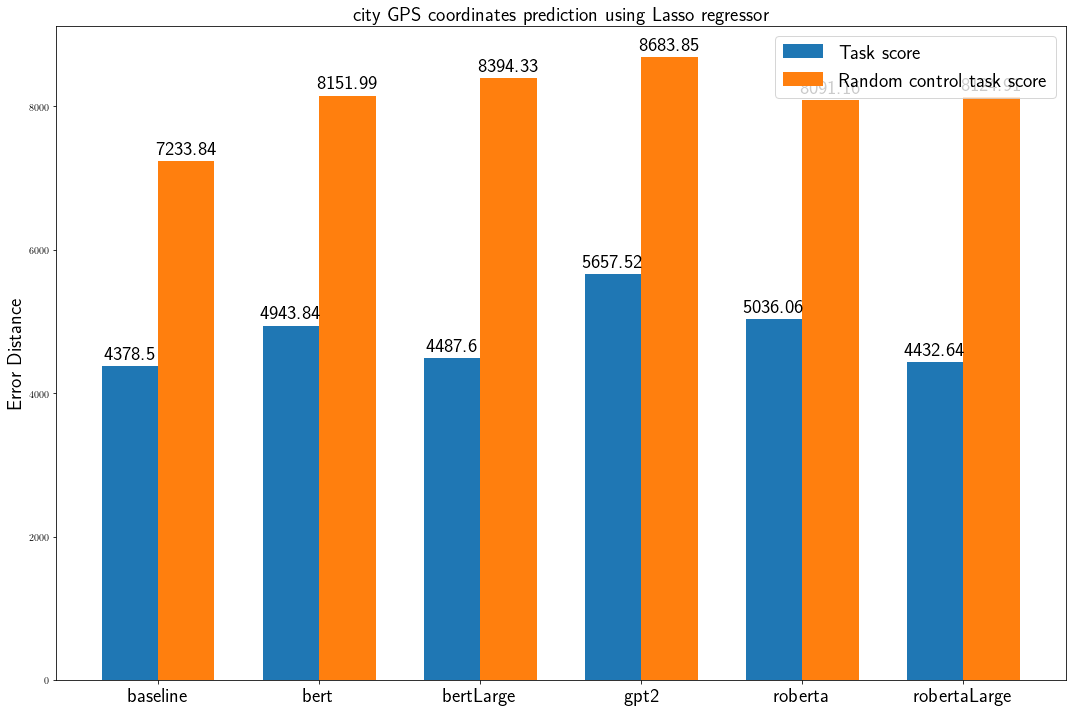

In [86]:
#warnings.filterwarnings("ignore")
coords_countries_scores_lasso = compare_models_wBaseline(model=linear_model.Lasso,model_kwargs={'max_iter':3000,'random_state':0,'alpha':0.5},
               datasets_dict=datasets_countries, baseline_embeddings = w2v_datasets['countries'],
               f_dataset=create_gps_dataset,f_dataset_kwargs={'for_countries':True},
               LMs=models,y_label='Error Distance',
               f_dataset_baseline_kwargs={'for_countries':True},
               fig_title='city GPS coordinates prediction using Lasso regressor',
              fig_name='final_countries_gps_lasso.png',n_test=10,metrics=gps_metrics,seed=0,return_scores=True,crossvalid=True)

warnings.filterwarnings("default")

bert -----------------------
random control:  40%|███████████▏                | 4/10 [04:12<06:37, 66.30s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.9672410190724, tolerance: 101.1657504523405
  positive)


random control: 100%|███████████████████████████| 10/10 [10:40<00:00, 64.02s/it]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [12:14<00:00, 73.50s/it]
gpt2 -----------------------
random control: 100%|███████████████████████████| 10/10 [04:23<00:00, 26.40s/it]
roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [15:11<00:00, 91.14s/it]
robertaLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [15:19<00:00, 91.97s/it]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [06:28<00:00, 38.89s/it]


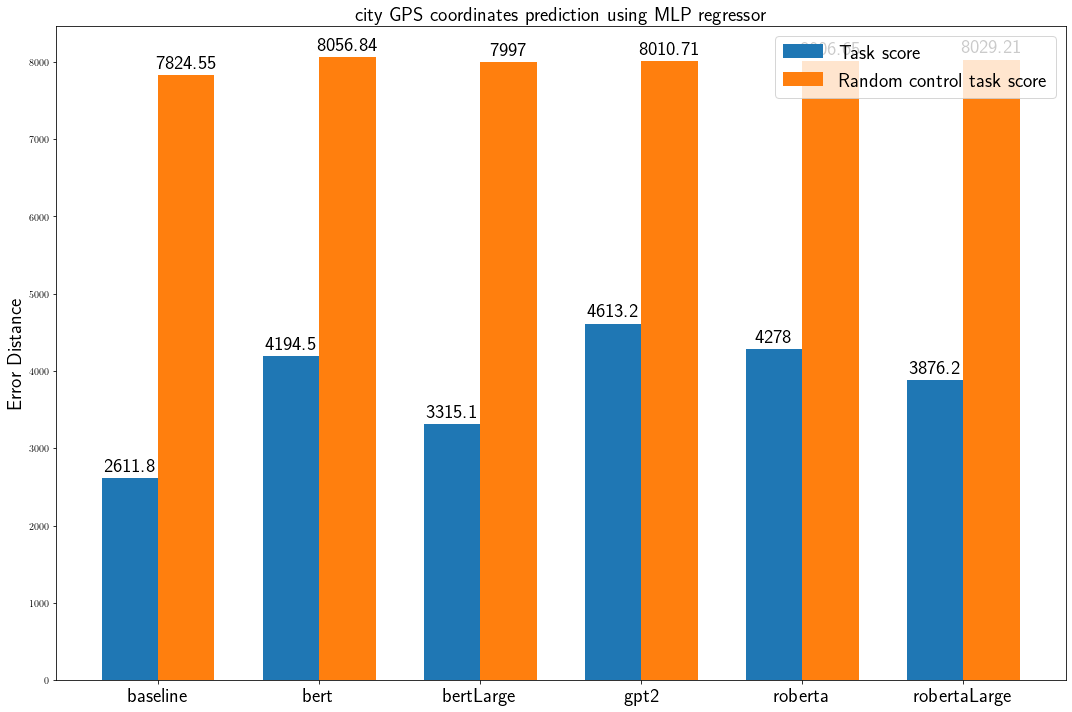

In [58]:
#warnings.filterwarnings("ignore")
coords_cities_scores = compare_models_wBaseline(model=MLPRegressor,model_kwargs={'max_iter':2000,'random_state':0},
               datasets_dict=datasets, baseline_embeddings = w2v_datasets['cities'],
               f_dataset=create_gps_dataset,f_dataset_kwargs={},
               LMs=models,y_label='Error Distance',
               f_dataset_baseline_kwargs={},
               fig_title='city GPS coordinates prediction using MLP regressor',
              fig_name='final_cities_gps_mlp.png',n_test=10,metrics=gps_metrics,seed=0,return_scores=True)

warnings.filterwarnings("default")

In [40]:
borders

{'AD': ['FR', 'ES'],
 'AE': ['OM', 'SA'],
 'AF': ['CN', 'IR', 'PK', 'TJ', 'TM', 'UZ'],
 'AG': [],
 'AI': [],
 'AL': ['GR', 'ME', 'MK', 'RS'],
 'AM': ['AZ', 'GE', 'IR', 'TR'],
 'AO': ['CG', 'CD', 'NA', 'ZM'],
 'AQ': [],
 'AR': ['BO', 'BR', 'CL', 'PY', 'UY'],
 'AS': [],
 'AT': ['CZ', 'DE', 'HU', 'IT', 'LI', 'SK', 'SI', 'CH'],
 'AU': [],
 'AW': [],
 'AX': [],
 'AZ': ['AM', 'GE', 'IR', 'RU', 'TR'],
 'BA': ['HR', 'ME', 'RS'],
 'BB': [],
 'BD': ['IN', 'MM'],
 'BE': ['FR', 'DE', 'LU', 'NL'],
 'BF': ['BJ', 'CI', 'GH', 'ML', 'NE', 'TG'],
 'BG': ['GR', 'MK', 'RO', 'RS', 'TR'],
 'BH': [],
 'BI': ['CD', 'RW', 'TZ'],
 'BJ': ['BF', 'NE', 'NG', 'TG'],
 'BL': [],
 'BM': [],
 'BN': ['MY'],
 'BO': ['AR', 'BR', 'CL', 'PY', 'PE'],
 'BQ': [],
 'BR': ['AR', 'BO', 'CO', 'GF', 'GY', 'PY', 'PE', 'SR', 'UY', 'VE'],
 'BS': [],
 'BT': ['CN', 'IN'],
 'BV': [],
 'BW': ['NA', 'ZA', 'ZM', 'ZW'],
 'BY': ['LV', 'LT', 'PL', 'RU', 'UA'],
 'BZ': ['GT', 'MX'],
 'CA': ['US'],
 'CC': [],
 'CD': ['AO', 'BI', 'CF', 'CG', 'RW',

In [101]:
task_scores = np.array([22112,26583,22559,32130,26375,22927])
rand_scores = np.array([17810,30063,31175,51171,28592,25924])
probe_scores = 1-(task_scores/rand_scores)

print(" & ".join(probe_scores.round(3).astype(str)))

-0.242 & 0.116 & 0.276 & 0.372 & 0.078 & 0.116


array(['0.6662044462620853', '0.4793864592073319', '0.5854570463923972',
       '0.42412095806738737', '0.4656941417446747', '0.5172376858993599'],
      dtype='<U32')

bert -----------------------
random control: 100%|███████████████████████████| 10/10 [01:21<00:00,  8.19s/it]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [00:58<00:00,  5.84s/it]
gpt2 -----------------------
random control:  10%|██▊                         | 1/10 [00:19<02:52, 19.18s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  30%|████████▍                   | 3/10 [00:54<02:07, 18.24s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  40%|███████████▏                | 4/10 [01:11<01:45, 17.62s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  60%|████████████████▊           | 6/10 [01:44<01:09, 17.25s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  70%|███████████████████▌        | 7/10 [02:03<00:53, 17.69s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  90%|█████████████████████████▏  | 9/10 [02:40<00:18, 18.12s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control: 100%|███████████████████████████| 10/10 [02:59<00:00, 17.91s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



roberta -----------------------
random control:  20%|█████▌                      | 2/10 [00:38<02:36, 19.55s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  30%|████████▍                   | 3/10 [00:57<02:14, 19.15s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lb

random control:  80%|██████████████████████▍     | 8/10 [02:22<00:35, 17.52s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  90%|█████████████████████████▏  | 9/10 [02:41<00:17, 17.86s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control: 100%|███████████████████████████| 10/10 [02:58<00:00, 17.83s/it]
robertaLarge -----------------------
random control:  30%|████████▍                   | 3/10 [01:05<02:37, 22.46s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  40%|███████████▏                | 4/10 [01:30<02:20, 23.44s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  60%|████████████████▊           | 6/10 [02:17<01:35, 23.75s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  70%|███████████████████▌        | 7/10 [02:42<01:12, 24.02s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control:  90%|█████████████████████████▏  | 9/10 [03:30<00:24, 24.20s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


random control: 100%|███████████████████████████| 10/10 [03:51<00:00, 23.18s/it]
baseline -----------------------
random control: 100%|███████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


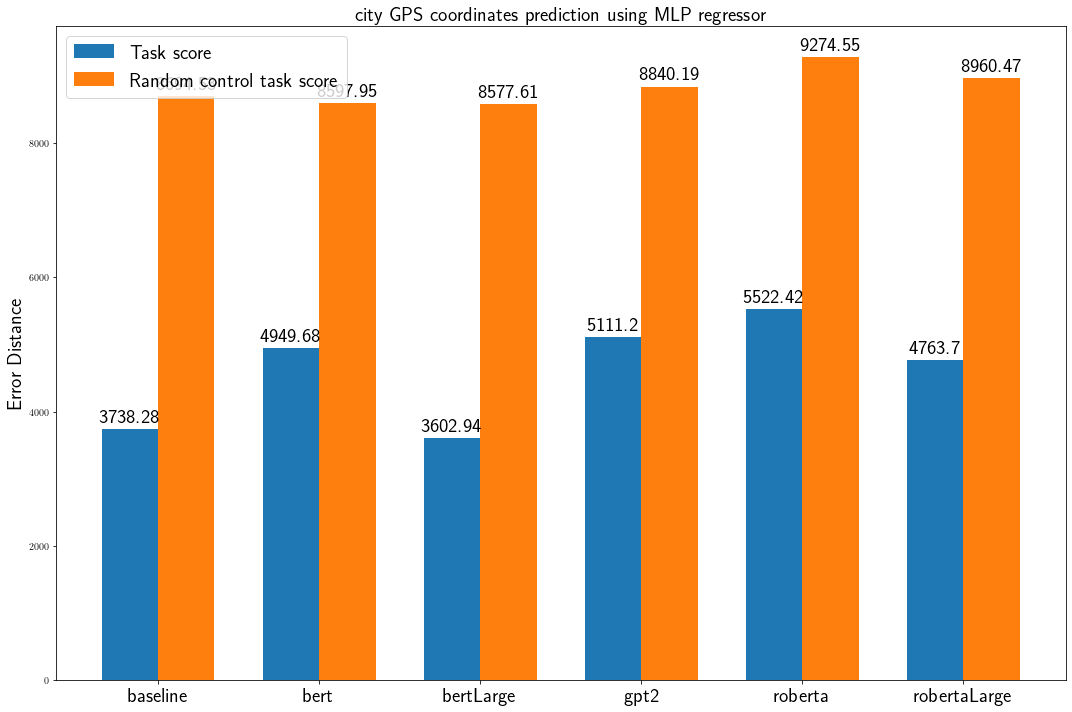

In [59]:
#warnings.filterwarnings("ignore")
coords_countries_scores = compare_models_wBaseline(model=MLPRegressor,model_kwargs={'max_iter':2000,'random_state':0,'solver':'lbfgs'},
               datasets_dict=datasets_countries, baseline_embeddings = w2v_datasets['countries'],
               f_dataset=create_gps_dataset,f_dataset_kwargs={'for_countries':True},
               LMs=models,y_label='Error Distance',
               f_dataset_baseline_kwargs={'for_countries':True},
               fig_title='city GPS coordinates prediction using MLP regressor',
              fig_name='final_countries_gps_mlp.png',n_test=10,metrics=gps_metrics,seed=0,return_scores=True,crossvalid=True)

warnings.filterwarnings("default")

In [186]:
model_name = 'w2v'

In [188]:
rsm_arr = np.load('./rsm/'+model_name+'_cities_RSM.npy')
isnotnan = ~np.isnan(rsm_arr)[0,:]
rsm_arr = rsm_arr[isnotnan,:][:,isnotnan]

<>:7: DeprecationWarning: invalid escape sequence \%
<>:7: DeprecationWarning: invalid escape sequence \%
<>:7: DeprecationWarning: invalid escape sequence \%
/tmp/ipykernel_2667/881796946.py:7: DeprecationWarning: invalid escape sequence \%
  plt.title('Representational Similarity Matrix for city names\n with '+model+' embeddings'+'\nAverage similarity : '+str(cut_arr.mean().round(4)*100)+'\%')


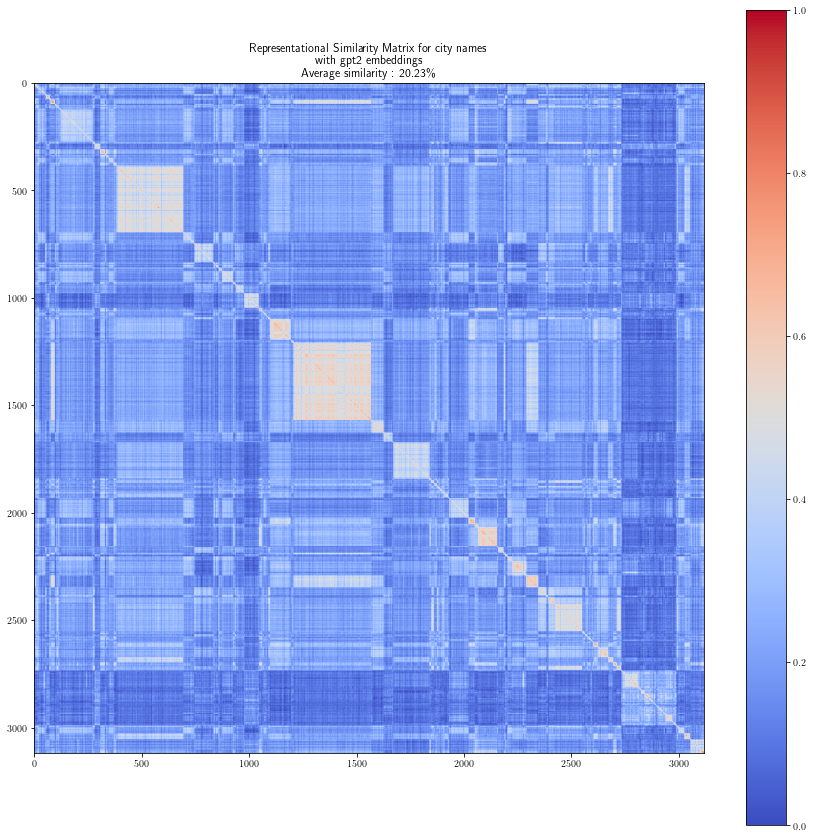

In [189]:
fig,ax=plt.subplots(1,figsize=(15,15))
fig.set_facecolor('white')
#cut_arr = get_patch(rsm_arr,'jp','jp') # focus on 1 country compared to another
cut_arr = rsm_arr #all countries
im = ax.imshow(cut_arr,vmin=0,vmax=1,cmap='coolwarm')
plt.colorbar(im)
plt.title('Representational Similarity Matrix for city names\n with '+model+' embeddings'+'\nAverage similarity : '+str(cut_arr.mean().round(4)*100)+'\%')
#plt.savefig('./img/RSM_'+model+'_cities.png',dpi=100,facecolor=fig.get_facecolor())
plt.show()

In [194]:
bins = 20
threshold_city_number = 5

hist_all_countries = np.histogram(flatten_triangle(rsm_arr),range=(0,1),density=True,bins=bins)

#countries_to_compare = ['cn','us','fr','es','in','ru','br','jp']
countries_to_compare = cities.Country.value_counts()[cities.Country.value_counts()>threshold_city_number].index

n = len(countries_to_compare)
# all_hists = np.empty( (n*(n+1)//2,len(hist_all_countries[0])))
# k = 0
# for i,country in tqdm(enumerate(countries_to_compare),desc='All Countries',total=n,file=sys.stdout,leave=True):
#     for j in range(i+1):
#         cut_arr = get_patch(rsm_arr,country,countries_to_compare[j],prefilter=isnotnan)
#         hist = np.histogram(flatten_triangle(cut_arr),range=(0,1),density=True,bins=bins)
#         all_hists[k] = hist[0]
#         k+=1
# all_mean_hist = np.mean(all_hists,axis=0)


intra_hists = np.empty( (n,len(hist_all_countries[0])))
for i,country in tqdm(enumerate(countries_to_compare),desc='Intra Country',total=n,file=sys.stdout,leave=True):
    cut_arr = get_patch(rsm_arr,country,country,prefilter=isnotnan)
    hist = np.histogram(flatten_triangle(cut_arr),range=(0,1),density=True,bins=bins)
    intra_hists[i] = hist[0]
    #ax.plot(x_range,hist[0],label=country+' ; '+str(cut_arr.mean().round(2)))
intra_mean_hist = np.mean(intra_hists,axis=0)

inter_hists = np.empty( (n*(n-1)//2,len(hist_all_countries[0])))
k = 0
for i,country in tqdm(enumerate(countries_to_compare),desc='Inter Country',total=n,file=sys.stdout,leave=True):
    for j in range(i):
        cut_arr = get_patch(rsm_arr,country,countries_to_compare[j],prefilter=isnotnan)
        hist = np.histogram(flatten_triangle(cut_arr),range=(0,1),density=True,bins=bins)
        inter_hists[k] = hist[0]
        k+=1
inter_mean_hist = np.mean(inter_hists,axis=0)


Inter Country: 100%|████████████████████████████| 78/78 [00:07<00:00, 10.59it/s]


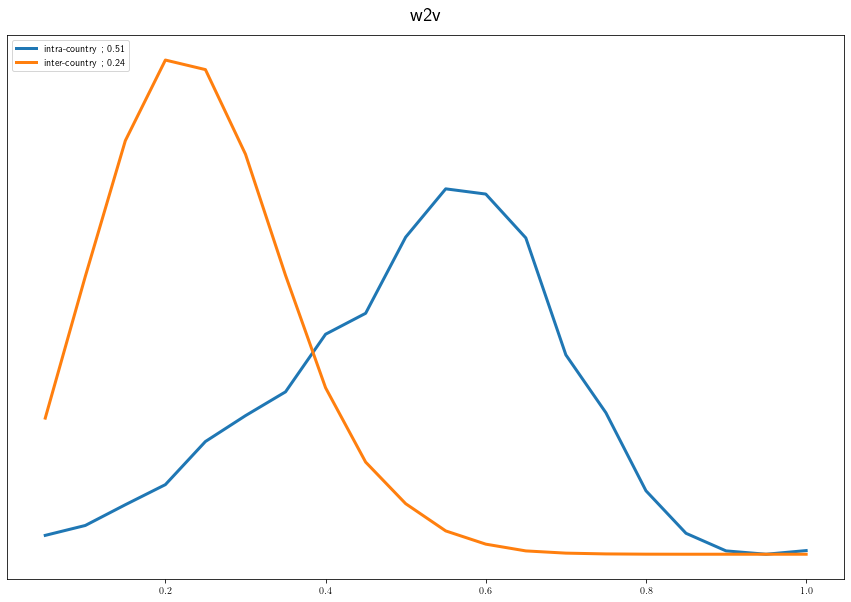

In [195]:
fig,ax = plt.subplots(1,figsize=(15,10))
fig.set_facecolor('white')

width = hist_all_countries[1][0]-hist_all_countries[1][0]
x_range = hist_all_countries[1][1:]+(width/2)

#ax.plot(x_range,all_mean_hist,label = 'all cities ; '+str((all_mean_hist*x_range).mean().round(2)),lw=3)
ax.plot(x_range,intra_mean_hist,label = 'intra-country ; '+str((intra_mean_hist*x_range).mean().round(2)),lw=3)
ax.plot(x_range,inter_mean_hist,label = 'inter-country ; '+str((inter_mean_hist*x_range).mean().round(2)),lw=3)


# plt.title('Histograms of similarity between cities \n(from countries in which there are more than '+str(threshold_city_number)
#           +' cities having min. 100k citizens)\nwith '+r'\textbf{'+model+'} embeddings',fontdict = {'fontsize' : 22})
plt.title(model_name,pad=15,fontsize=20)
plt.legend(loc='upper left')
plt.tick_params(left = False, right = False , labelleft = False)
plt.savefig('./img/SimHist_'+model_name+'_cities.png',dpi=100,facecolor=fig.get_facecolor())
plt.show()